In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import compute_class_weight
from collections import Counter
import keras
from tf_keras.src.losses import mean_squared_error

Get the input and label files from CSVs

In [35]:
def filter_sequences(x_sequences, y_sequences, model):
    filtered_x_sequences = []
    filtered_y_sequences = []
    if model == 'Model I':
        for x_seq, y_seq in zip(x_sequences, y_sequences):
            if np.any(y_seq[:, 1:] != 0) or (np.sum(y_seq[:, 0] != 0) < 2 and np.any(y_seq[:, 0] != 0)):
                filtered_x_sequences.append(x_seq)
                filtered_y_sequences.append(y_seq)
    else:
        for x_seq, y_seq in zip(x_sequences, y_sequences):
            if np.any(y_seq[:, 1:] != 0):
                filtered_x_sequences.append(x_seq)
                filtered_y_sequences.append(y_seq)
            
    return filtered_x_sequences,filtered_y_sequences

In [36]:
def get_train_test_splitted_data(label_files, input_files, global_mean, global_std, test_size=0.2, random_state=42):

    all_x_sequences = []
    all_y_sequences = []
    # Process each pair of input and label files
    for input_file, label_file in zip(input_files, label_files):

        input_df = pd.read_csv(input_file)
        if label_file.endswith('BORIS_method_II.csv'):
            model = 'Model II'
            label_df = pd.read_csv(label_file)
            labels = label_df.values / 100
        else:
            model = 'Model I'
            label_df = pd.read_csv(label_file, dtype=str, na_values=[])   
            column_names = ['Happy', 'Sad', 'Scared', 'Disgusted', 'Surprised', 'Angry']

            encoder = OneHotEncoder(categories=[column_names], handle_unknown='ignore')

            # Fit and transform the label data
            labels = pd.DataFrame(
                encoder.fit_transform(label_df).toarray(),
                columns=encoder.get_feature_names_out()
            )

        features = (input_df.values - global_mean) / global_std
        
        if features.shape[0] != labels.shape[0]:
            print(f"Mismatch in frames: {input_file}, {label_file}")
            continue
            
        # Sample sequences
        x_sequences, y_sequences = create_sequences(features, labels, SEQUENCE_LENGTH, STRIDE)
        filtered_x_sequences, filtered_y_sequences = filter_sequences(x_sequences, y_sequences, model)
        # Append to global lists
        if filtered_x_sequences and filtered_y_sequences:
            all_x_sequences.append(filtered_x_sequences)
            all_y_sequences.append(filtered_y_sequences)
            
    all_x_sequences = np.concatenate(all_x_sequences, axis=0)
    all_y_sequences = np.concatenate(all_y_sequences, axis=0)
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        all_x_sequences, all_y_sequences, test_size=test_size, random_state=random_state
    )

    # Convert to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # Shuffle, batch, and prefetch
    train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

    return train_dataset, test_dataset

In [46]:
def count_method_I(all_y_sequences):
    label_counts = Counter()
    emotion_labels = ['Happy', 'Sad', 'Disgusted', 'Surprised', 'Angry', 'Scared']

    for y_sequence in all_y_sequences:
        # Loop through each timestamp in the sequence
        if np.all(y_sequence == 0):
            # Count as 'Neutral' if all values are zero
            label_counts['Neutral'] += 1            
        else:
            # Find the label corresponding to the max value (one-hot or normalized)
            label_index = np.argmax(y_sequence)
            label_counts[emotion_labels[label_index]] += 1
    
    total_labels = sum(label_counts.values())
    df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
    
    # Add a new column for percentage
    df['Percentage'] = (df['Count'] / total_labels * 100).round(2).astype(str) + '%'  # Format as percentage
    
    # Reset the index to have labels as a column
    df = df.reset_index().rename(columns={'index': 'Label'})
    
    return df

       Label  Count Percentage
0    Neutral   5557      75.3%
1        Sad    613      8.31%
2      Happy    348      4.72%
3  Surprised     42      0.57%
4      Angry     94      1.27%
5     Scared     94      1.27%
6  Disgusted    632      8.56%


In [18]:
def count_method_II(all_y_sequences):
    
    combined_df = pd.DataFrame(all_y_sequences)

    emotion_labels = ['Happy', 'Sad', 'Disgusted', 'Surprised', 'Angry', 'Scared']
    
    # Calculate the number of rows where each emotion is non-zero
    non_zero_counts = (combined_df != 0).sum()  
    total_rows = len(combined_df)  
    print(total_rows)
    
    neutral_count = (combined_df.sum(axis=1) == 0).sum()
    non_zero_counts["Neutral"] = neutral_count
    
    result_df = pd.DataFrame(non_zero_counts.items(), columns=['Label', 'Count'])
    # Calculate the percentage for each label
    result_df['Percentage'] = ((result_df['Count'] / total_rows) * 100).round(2).astype(str) + '%'

        # Create a mapping from numbers to emotion labels
    label_mapping = {i: emotion_labels[i] for i in range(len(emotion_labels))}
    
    # Replace the numerical labels with the corresponding emotion labels
    result_df['Label'] = result_df['Label'].replace(label_mapping)
    
    return(result_df)

In [2]:
# Hyperparameters
SEQUENCE_LENGTH = 20
STRIDE = 10
BATCH_SIZE = 32
INPUT_DIM = 515  
OUTPUT_DIM = 6 

In [7]:
def create_sequences(features, labels, sequence_length, stride):
    x_sequences, y_sequences = [], []
    for i in range(0, len(features) - sequence_length + 1, stride):
        x_sequences.append(features[i:i + sequence_length])
        y_sequences.append(labels[i:i + sequence_length])
    return np.array(x_sequences), np.array(y_sequences)

all_x_sequences = []
all_y_sequences = []
all_features = []

sources = ["GUT", "ITU-YU", "MAAP"]
base_path = "//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/"
input_files, label_files = [], []

for source in sources:
    input_files.extend(glob.glob(os.path.join(base_path, source, '*_input.csv')))
    label_files.extend(glob.glob(os.path.join(base_path, source, '*_BORIS.csv')))

input_files.sort()
label_files.sort()

for input_file in input_files:
    input_df = pd.read_csv(input_file)
    all_features.append(input_df.values)

all_features = np.concatenate(all_features, axis=0)

num_columns = all_features.shape[1]
global_mean_zero = np.zeros(num_columns)
global_std_zero = np.zeros(num_columns)

# Compute column-wise statistics ignoring zeros
for col in range(num_columns):
    non_zero_col = all_features[:, col][all_features[:, col] != 0]  # Filter non-zero values
    if non_zero_col.size > 0:  # Avoid empty arrays
        global_mean_zero[col] = np.mean(non_zero_col)
        global_std_zero[col] = np.std(non_zero_col, ddof=1)  # Use sample std dev
    else:
        global_mean_zero[col] = 0  # Default if no non-zero elements
        global_std_zero[col] = 0

global_mean = np.array(global_mean_zero)
global_std = np.array(global_std_zero)

In [6]:
GUT_path_input = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_input.csv'))
ITU_YU_path_input = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_input.csv'))
MAAP_path_input = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_input.csv'))

GUT_path_label_method_I = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_BORIS_method_I.csv'))
ITU_YU_path_label_method_I = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_BORIS_method_I.csv'))
MAAP_path_label_method_I = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_BORIS_method_I.csv'))

GUT_path_label_method_II = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_BORIS_method_II.csv'))
ITU_YU_path_label_method_II = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_BORIS_method_II.csv'))
MAAP_path_label_method_II = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_BORIS_method_II.csv'))

In [ ]:
GUT_train_method_I, GUT_test_method_I = get_train_test_splitted_data(GUT_path_label_method_I, GUT_path_input, global_mean, global_std, test_size=0.3)
ITU_YU_train_method_I, ITU_YU_test_method_I = get_train_test_splitted_data(ITU_YU_path_label_method_I, ITU_YU_path_input, global_mean, global_std, test_size=0.3)
MAAP_train_method_I, MAAP_test_method_I = get_train_test_splitted_data(MAAP_path_label_method_I, MAAP_path_input, global_mean, global_std, test_size=0.3)

GUT_train_method_II, GUT_test_method_II = get_train_test_splitted_data(GUT_path_label_method_II, GUT_path_input, global_mean, global_std, test_size=0.3)
ITU_YU_train_method_II, ITU_YU_test_method_II = get_train_test_splitted_data(ITU_YU_path_label_method_II, ITU_YU_path_input, global_mean, global_std, test_size=0.3)
MAAP_train_method_II, MAAP_test_method_II = get_train_test_splitted_data(MAAP_path_label_method_II, MAAP_path_input, global_mean, global_std, test_size=0.3)

dataset_method_I = GUT_train_method_I.concatenate(ITU_YU_train_method_I).concatenate(MAAP_train_method_I)
dataset_method_II = GUT_train_method_II.concatenate(ITU_YU_train_method_II).concatenate(MAAP_train_method_II)

In [16]:
import pandas as pd
import numpy as np

all_features = []

for input_file in input_files:
    input_df = pd.read_csv(input_file)
    
    if input_df.isnull().values.any():
        print(f"NaN found in file: {input_file}")
    
    all_features.append(input_df.values)

In [342]:
path = r'Z:\IO3-sessions\NEW STRUCTURE\de-earlyfusionthesis\Datasets' # Z is the mapped network drive to //153.19.52.107/emboa

tf.data.Dataset.save(dataset_method_I ,os.path.join(path, 'train_dataset_method_I_balanced'))
tf.data.Dataset.save(GUT_train_method_I, os.path.join(path, 'GUT_train_method_I_balanced'))
tf.data.Dataset.save(GUT_test_method_I, os.path.join(path, 'GUT_test_method_I_balanced'))
tf.data.Dataset.save(ITU_YU_train_method_I, os.path.join(path, 'ITU_YU_train_method_I_balanced'))
tf.data.Dataset.save(ITU_YU_test_method_I, os.path.join(path, 'ITU_YU_test_method_I_balanced'))
tf.data.Dataset.save(MAAP_train_method_I, os.path.join(path, 'MAAP_train_method_I_balanced'))
tf.data.Dataset.save(MAAP_test_method_I, os.path.join(path, 'MAAP_test_method_I_balanced'))

tf.data.Dataset.save(dataset_method_II ,os.path.join(path, 'train_dataset_method_II_balanced'))
tf.data.Dataset.save(GUT_train_method_II, os.path.join(path, 'GUT_train_method_II_balanced'))
tf.data.Dataset.save(GUT_test_method_II, os.path.join(path, 'GUT_test_method_II_balanced'))
tf.data.Dataset.save(ITU_YU_train_method_II, os.path.join(path, 'ITU_YU_train_method_II_balanced'))
tf.data.Dataset.save(ITU_YU_test_method_II, os.path.join(path, 'ITU_YU_test_method_II_balanced'))
tf.data.Dataset.save(MAAP_train_method_II, os.path.join(path, 'MAAP_train_method_II_balanced'))
tf.data.Dataset.save(MAAP_test_method_II, os.path.join(path, 'MAAP_test_method_II_balanced'))

In [3]:
path = r'Z:\IO3-sessions\NEW STRUCTURE\de-earlyfusionthesis\Datasets'

train_dataset_path_I = os.path.abspath(os.path.join(path, 'train_dataset_method_I_balanced'))
GUT_test_path_I = os.path.join(path, 'GUT_test_method_I_balanced').replace("\\", "/")
ITU_YU_test_path_I = os.path.join(path, 'ITU_YU_test_method_I_balanced').replace("\\", "/")
MAAP_test_path_I = os.path.join(path, 'MAAP_test_method_I_balanced').replace("\\", "/")

train_dataset_path_II = os.path.abspath(os.path.join(path, 'train_dataset_method_II_balanced'))
GUT_test_path_II = os.path.join(path, 'GUT_test_method_II_balanced').replace("\\", "/")
ITU_YU_test_path_II = os.path.join(path, 'ITU_YU_test_method_II_balanced').replace("\\", "/")
MAAP_test_path_II = os.path.join(path, 'MAAP_test_method_II_balanced').replace("\\", "/")

# Load datasets
train_I = tf.data.Dataset.load(train_dataset_path_I)
GUT_test_I = tf.data.Dataset.load(GUT_test_path_I)
ITU_YU_test_I = tf.data.Dataset.load(ITU_YU_test_path_I)
MAAP_test_I = tf.data.Dataset.load(MAAP_test_path_I)

train_II = tf.data.Dataset.load(train_dataset_path_II)
GUT_test_II = tf.data.Dataset.load(GUT_test_path_II)
ITU_YU_test_II = tf.data.Dataset.load(ITU_YU_test_path_II)
MAAP_test_II = tf.data.Dataset.load(MAAP_test_path_II)

full_test_I = GUT_test_I.concatenate(ITU_YU_test_I).concatenate(MAAP_test_I)
full_test_II = GUT_test_II.concatenate(ITU_YU_test_II).concatenate(MAAP_test_II)

## MODEL I

In [4]:
path = r'Z:\IO3-sessions\NEW STRUCTURE\de-earlyfusionthesis\Models'

In [16]:
@keras.saving.register_keras_serializable(package="my_package", name="custom_fn")
def masked_categorical_crossentropy(y_true, y_pred):

    # Create a mask: 1 for valid labels (non-[0, 0, 0]), 0 for "Unknown" ([0, 0, 0])
    mask = tf.reduce_sum(y_true, axis=-1) > 0
    mask = tf.cast(mask, tf.float32)  

    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    loss = loss * mask
    
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [99]:
model_I = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQUENCE_LENGTH, INPUT_DIM)),    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),  
    tf.keras.layers.Dense(64, activation='relu'),  
    tf.keras.layers.Dense(32, activation='relu'),                
    tf.keras.layers.Dense(OUTPUT_DIM, activation='softmax')     
])

In [102]:
model_I.compile(optimizer='adam', loss=masked_categorical_crossentropy, metrics=['accuracy'])

In [103]:
history = model_I.fit(train_I, epochs=100, batch_size=BATCH_SIZE)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.0157 - loss: 0.4206
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0258 - loss: 0.4243
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0278 - loss: 0.4769
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0319 - loss: 0.4545
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0609 - loss: 0.4211
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0603 - loss: 0.3968
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0584 - loss: 0.3817
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0378 - loss: 0.3987
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0260 - loss: 0.4171
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0343 - loss: 0.4150
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0436 - loss: 0.4083
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/ste

In [20]:
model_I.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 20, 128)        │       296,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20, 6)          │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 922,484 (3.52 MB)

 Trainable params: 307,494 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 614,990 (2.35 MB)

In [21]:
# Evaluate the model
loss, acc = model_I.evaluate(full_test_I, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(acc))

5/5 - 2s - 392ms/step - accuracy: 0.5433 - loss: 0.7468
Untrained model, accuracy:  0.54%


In [22]:
model_I.save(os.path.join(path, 'model_method_I/model.keras'))

## MODEL II

In [203]:
@keras.saving.register_keras_serializable(package="my_package", name="custom_fn")
def masked_mean_squared_error(y_true, y_pred):

    # Create a mask: 1 for valid labels (non-[0, 0, 0]), 0 for "Unknown" ([0, 0, 0])
    mask = tf.reduce_sum(y_true, axis=-1) > 0 
    mask = tf.cast(mask, tf.float32)
    
    loss = tf.square(y_true - y_pred)
    
    masked_loss = loss * mask[..., tf.newaxis]  # Zero out loss for "Unknown" labels
    
    return tf.reduce_sum(masked_loss) / tf.reduce_sum(mask)

In [204]:
model_II = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQUENCE_LENGTH, INPUT_DIM)),  
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),             
    tf.keras.layers.Dense(OUTPUT_DIM, activation='sigmoid')     
])

In [205]:
model_II.compile(optimizer='adam', loss=masked_mean_squared_error, metrics=['mse'])

In [206]:
labels = []

for inputs, label in train_II:
    labels.append(label)

y_train = np.concatenate(labels, axis=0)  # Stack labels into a single array
y_train_flat = y_train.reshape(-1, 6)  # Flattening the labels
y_train_classes = np.argmax(y_train_flat, axis=-1)  # Get the class labels for each timestamp

# Calculate class weights based on the frequency of each class
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [207]:
history = model_II.fit(train_II, epochs=75, batch_size=BATCH_SIZE, class_weight=class_weight_dict, verbose=0)

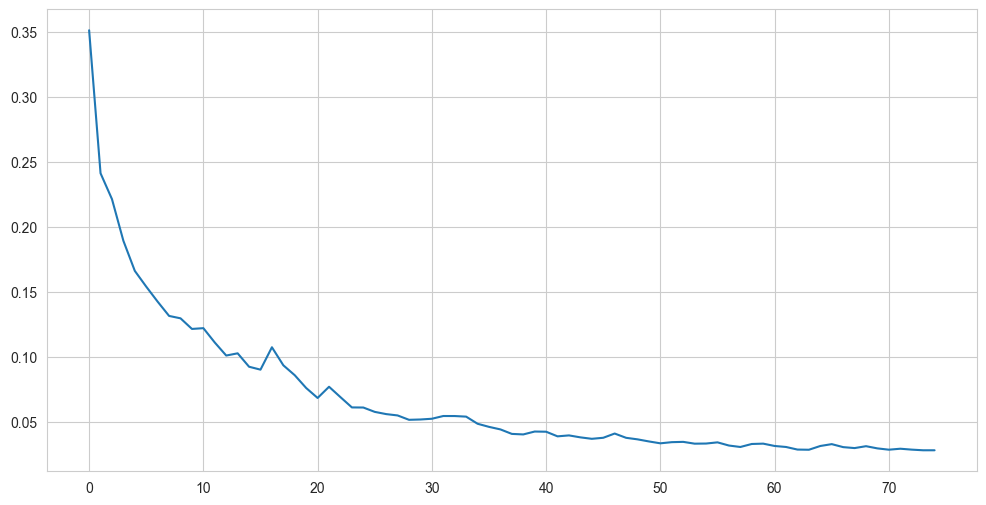

In [208]:
import matplotlib.pyplot as plt

history_dict = history.history

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Training Loss')
if 'val_loss' in history_dict:
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 0.5)
    plt.show()

In [209]:
test_set = full_test_II

y_pred = model_II.predict(test_set.map(lambda x, _: x))
y_true = tf.concat([y for _, y in test_set], axis=0)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step


In [39]:
model_II.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 20, 128)        │       296,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20, 6)          │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 922,484 (3.52 MB)

 Trainable params: 307,494 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 614,990 (2.35 MB)

In [210]:
# Evaluate the model
loss, acc = model_II.evaluate(full_test_II, verbose=2)
print("Untrained model, coherence: {:5.2f}%".format(100 * (1-acc)))

13/13 - 3s - 211ms/step - loss: 0.1051 - mse: 0.0192
Untrained model, coherence: 98.08%


In [214]:
model_II.save(os.path.join(path, 'model_method_II/model.keras'))